In [1]:
%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=4)

import matplotlib.pyplot as plt
%matplotlib inline

import featuretools as ft

In [2]:
train = pd.read_csv('/home/dissertation/data/train_v2.csv', 
                          dtype = {'msno' : 'category'})

members = pd.read_csv('/home/dissertation/data/members_v3.csv',
                            dtype={'registered_via' : np.uint8,
                                   'gender' : str,
                                   'city' : 'category',
                                   'registered_via' : 'category'})

members['registration_init_time_dt'] = pd.to_datetime(members['registration_init_time'], 
                                                            format='%Y%m%d', errors='ignore')

## Next load in the transactions data
transactions = pd.read_csv('/home/dissertation/data/transactions.csv',
                                 dtype = {'payment_method' : 'category',
                                          'payment_plan_days' : np.uint8,
                                          'plan_list_price' : np.uint8,
                                          'actual_amount_paid': np.uint8,
                                          'is_auto_renew' : np.bool,
                                          'is_cancel' : np.bool})


In [25]:
train.head()

,msno,is_churn
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1


,msno,city,bd,gender,registered_via,registration_init_time,registration_init_time_dt
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,5,28,male,3,20131223,2013-12-23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,13,20,male,3,20131223,2013-12-23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,13,18,male,3,20131227,2013-12-27
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0,unknown,7,20140109,2014-01-09
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,13,35,female,7,20140125,2014-01-25


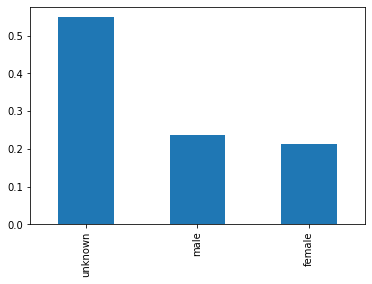

In [3]:
merged_input = pd.merge(left=train, right=members, how='inner', on=['msno'])
merged_input.drop(['is_churn'], axis=1, inplace=True)

merged_input['gender'] = merged_input['gender'].fillna(value='unknown')
merged_input.gender.value_counts(normalize=True).plot(kind='bar')

merged_input.head()

In [4]:
transactions = pd.merge(train['msno'], transactions, on='msno', how='inner')
len(transactions)

15123586

In [6]:
# Difference between listing price and price paid
transactions['price_difference'] = transactions['plan_list_price'] - transactions['actual_amount_paid']

### IS THIS OK?
transactions.loc[transactions.payment_plan_days == 0, 'payment_plan_days'] = 30

# Planned price per day
transactions['planned_daily_price'] = transactions['plan_list_price'] / transactions['payment_plan_days']

# Actual price per day
transactions['daily_price'] = transactions['actual_amount_paid'] / transactions['payment_plan_days']

In [7]:
import featuretools.variable_types as vtypes

# Make empty entityset
es = ft.EntitySet(id = 'customers')

In [8]:
# Create entity from members
es.entity_from_dataframe(entity_id='members', dataframe=merged_input,
                         index = 'msno', time_index = 'registration_init_time', 
                         variable_types = {'city': vtypes.Categorical, 
                                           'registered_via': vtypes.Categorical})

Entityset: customers
  Entities:
    members [Rows: 860967, Columns: 7]
  Relationships:
    No relationships

In [9]:
# Create entity from transactions
es.entity_from_dataframe(entity_id='transactions', dataframe=transactions,
                         index = 'transactions_index', make_index = True,
                         time_index = 'transaction_date', 
                         variable_types = {'payment_method_id': vtypes.Categorical, 
                                           'is_auto_renew': vtypes.Boolean, 'is_cancel': vtypes.Boolean})

Entityset: customers
  Entities:
    members [Rows: 860967, Columns: 7]
    transactions [Rows: 15123586, Columns: 13]
  Relationships:
    No relationships

In [10]:
# Relationships (parent, child)
r_member_transactions = ft.Relationship(es['members']['msno'], es['transactions']['msno'])
es.add_relationships([r_member_transactions])

Entityset: customers
  Entities:
    members [Rows: 860967, Columns: 7]
    transactions [Rows: 15123586, Columns: 13]
  Relationships:
    transactions.msno -> members.msno

In [ ]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      where_primitives = ['sum', 'mean'],
                      max_depth=2, features_only=True)

In [ ]:
print(f'This will generate {len(feature_defs)} features.')

In [ ]:
import random; random.seed(42)

random.sample(feature_defs, 10)

In [ ]:
all_p = ft.list_primitives()
trans_p = all_p.loc[all_p['type'] == 'transform'].copy()
agg_p = all_p.loc[all_p['type'] == 'aggregation'].copy()

pd.options.display.max_colwidth = 100
agg_p.head()

In [18]:
# Specify aggregation primitives
agg_primitives = ['sum', 'time_since_last', 'avg_time_between', 'all', 'mode', 'num_unique', 'min', 'last', 
                  'mean', 'percent_true', 'max', 'std', 'count']

In [19]:
# Specify transformation primitives
trans_primitives = ['day', 'month', 'diff', 'time_since_previous']

In [20]:
# Specify where primitives
where_primitives = ['sum', 'mean']#, 'percent_true', 'all', 'any']

In [21]:
feature_defs = ft.dfs(entityset=es, target_entity='members', 
                      agg_primitives = agg_primitives,
                      trans_primitives = trans_primitives,
                      where_primitives = where_primitives,
                      cutoff_time_in_index = True,
                      max_depth = 2, features_only = True)

In [22]:
print(f'This will generate {len(feature_defs)} features.')

This will generate 168 features.


In [24]:
from timeit import default_timer as timer

start = timer()
feature_matrix, feature_defs = ft.dfs(entityset=es, target_entity='members', 
                                      agg_primitives = agg_primitives,
                                      trans_primitives = trans_primitives,
                                      where_primitives = where_primitives,
                                      max_depth = 2, features_only = False,
                                      verbose = 1, chunk_size = 1000,  
                                      n_jobs = 1,
                                      cutoff_time_in_index = True)
end = timer()
print(f'{round(end - start)} seconds elapsed.')

Built 168 features
Elapsed: 39:52 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 861/861 chunks
2405 seconds elapsed.


In [ ]:
dfs_abt = pd.merge(train, feature_matrix, on = ['msno'], how = 'inner')

In [ ]:
dfs_abt.head()

In [ ]:
dfs_abt.to_hdf('/home/dissertation/data/dfs_dataset.h5', key='dfs_dataset', mode='w', format='table')